In [1]:
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_loader import (
    load_mergesort_results,
    load_radixsort_results,
)

In [2]:
ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR / 'data'

In [3]:
MERGE_SORT_DIR = DATA_DIR / 'mergeSortResults'
RADIX_SORT_DIR = DATA_DIR / 'radixSortResults'

In [4]:
def show(df: pd.DataFrame, lines: int = 5) -> None:
    display(df.head(lines))
    print(f"Shape: {df.shape}")


def aggregate_data(
    df: pd.DataFrame,
    groupby_columns: List[str],
    round_to: int = 0,
) -> pd.DataFrame:
    """Compute the mean time for each group of experiments,
    std and confidence interval.
    Args:
        df: DataFrame with the data
        groupby_columns: Columns to group by
    Returns:
        DataFrame with the mean time for each group of experiments
    """
    means = df.groupby(groupby_columns).agg(
        mean_time=("time", "mean"),
        std_time=("time", "std"),
        ci_time=("time", lambda x: 1.96 * np.std(x) / np.sqrt(len(x))),
    )

    means["ci_time"] = means.apply(
        lambda x: (
            round(x["mean_time"] - x["ci_time"], round_to),
            round(x["mean_time"] + x["ci_time"], round_to),
        ),
        axis=1,
    )

    means = means.round(round_to)
    if round_to == 0:
        means["mean_time"] = means["mean_time"].astype(int)
        means["std_time"] = means["std_time"].astype(int)
        means["ci_time"] = means["ci_time"].apply(lambda x: (int(x[0]), int(x[1])))
    return means.reset_index()


def get_optimal_bucket_size(
    radix_df: pd.DataFrame,
    time_column: str = "time",
) -> pd.DataFrame:
    """Returns a dataframe with the optimal bucket size for each universe."""
    min_time_index = radix_df.groupby("universe")[time_column].idxmin()
    return radix_df.loc[min_time_index].reset_index(drop=True)

In [5]:
FIRST_EXPERIMENT = 101
LAST_EXPERIMENT = 200
MAX_BUCKET_SIZE = 26

mergesort = load_mergesort_results(MERGE_SORT_DIR)
mergesort = mergesort[
    (mergesort["experiment"] >= FIRST_EXPERIMENT)
    & (mergesort["experiment"] <= LAST_EXPERIMENT)
]

radixsort = load_radixsort_results(RADIX_SORT_DIR)
radixsort = radixsort[
    (radixsort["experiment"] >= FIRST_EXPERIMENT)
    & (radixsort["bucket_size"] <= MAX_BUCKET_SIZE)
    & (radixsort["experiment"] <= LAST_EXPERIMENT)
]

In [6]:
ROUND_TO = 0

mergesort = aggregate_data(
    mergesort,
    groupby_columns=["universe"],
    round_to=ROUND_TO,
)

radixsort = aggregate_data(
    radixsort,
    groupby_columns=["universe", "bucket_size"],
    round_to=ROUND_TO,
)

In [7]:
show(mergesort)
show(radixsort)

,universe,mean_time,std_time,ci_time
0,1,3216,12,"(3210, 3222)"
1,2,3409,71,"(3373, 3445)"
2,3,3490,16,"(3482, 3499)"
3,4,3564,14,"(3557, 3571)"
4,5,3630,15,"(3622, 3637)"


Shape: (64, 4)


,universe,bucket_size,mean_time,std_time,ci_time
0,1,1,546,12,"(539, 552)"
1,2,1,786,16,"(778, 794)"
2,2,2,543,11,"(537, 548)"
3,3,1,1030,24,"(1018, 1042)"
4,3,2,543,12,"(537, 549)"


Shape: (1339, 5)


In [9]:
mergesort = mergesort.sort_values("universe")
optimal_radix = get_optimal_bucket_size(radixsort, time_column="mean_time")
optimal_radix = optimal_radix.sort_values("universe")

Text(0.5, 1.0, 'Bucket size vs Universe')

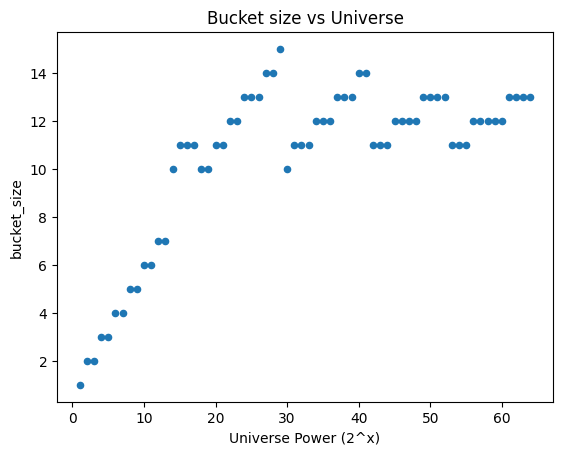

In [37]:
optimal_radix.plot(x="universe", y="bucket_size", kind="scatter")
plt.xlabel("Universe Power (2^x)")

plt.title("Bucket size vs Universe")

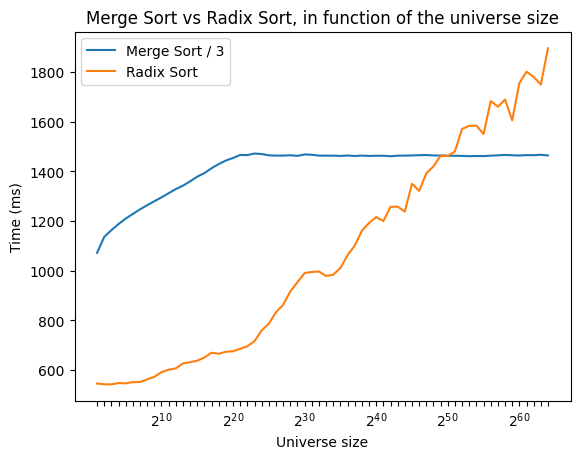

In [27]:
plt.plot(
    mergesort["universe"],
    mergesort["mean_time"] / 3,
    label="Merge Sort / 3",
)
plt.plot(
    optimal_radix["universe"],
    optimal_radix["mean_time"],
    label="Radix Sort",
)


new_labels = [
    "$2^{{{}}}$".format(x) if x % 10 == 0 else "" for x in mergesort["universe"]
]

plt.xticks(mergesort["universe"], new_labels)


plt.xlabel("Universe size")
plt.ylabel("Time (ms)")
plt.title(
    "Merge Sort vs Radix Sort, in function of the universe size"
)
plt.legend()

In [28]:
optimal_radix

,universe,bucket_size,mean_time,std_time,ci_time
0,1,1,546,12,"(539, 552)"
1,2,2,543,11,"(537, 548)"
2,3,2,543,12,"(537, 549)"
3,4,3,548,13,"(541, 554)"
4,5,3,547,14,"(540, 554)"
...,...,...,...,...,...
59,60,12,1755,123,"(1688, 1821)"
60,61,13,1801,161,"(1713, 1888)"
61,62,13,1780,198,"(1672, 1887)"
62,63,13,1749,221,"(1629, 1869)"


In [41]:
optimal_radix

,universe,bucket_size,mean_time,std_time,ci_time
0,1,1,546,12,"(539, 552)"
1,2,2,543,11,"(537, 548)"
2,3,2,543,12,"(537, 549)"
3,4,3,548,13,"(541, 554)"
4,5,3,547,14,"(540, 554)"
...,...,...,...,...,...
59,60,12,1755,123,"(1688, 1821)"
60,61,13,1801,161,"(1713, 1888)"
61,62,13,1780,198,"(1672, 1887)"
62,63,13,1749,221,"(1629, 1869)"


In [40]:
print(optimal_radix.to_latex(index=False))

\begin{tabular}{rrrrl}
\toprule
universe & bucket_size & mean_time & std_time & ci_time \\
\midrule
1 & 1 & 546 & 12 & (539, 552) \\
2 & 2 & 543 & 11 & (537, 548) \\
3 & 2 & 543 & 12 & (537, 549) \\
4 & 3 & 548 & 13 & (541, 554) \\
5 & 3 & 547 & 14 & (540, 554) \\
6 & 4 & 552 & 14 & (545, 559) \\
7 & 4 & 552 & 15 & (545, 560) \\
8 & 5 & 563 & 13 & (556, 569) \\
9 & 5 & 573 & 17 & (564, 581) \\
10 & 6 & 592 & 9 & (588, 597) \\
11 & 6 & 602 & 10 & (597, 608) \\
12 & 7 & 607 & 8 & (603, 611) \\
13 & 7 & 627 & 14 & (620, 634) \\
14 & 10 & 632 & 6 & (629, 635) \\
15 & 11 & 638 & 10 & (633, 643) \\
16 & 11 & 651 & 11 & (646, 657) \\
17 & 11 & 670 & 14 & (662, 677) \\
18 & 10 & 666 & 19 & (656, 675) \\
19 & 10 & 674 & 18 & (664, 683) \\
20 & 11 & 676 & 10 & (671, 681) \\
21 & 11 & 686 & 11 & (681, 692) \\
22 & 12 & 696 & 16 & (688, 703) \\
23 & 12 & 717 & 34 & (700, 735) \\
24 & 13 & 760 & 20 & (750, 770) \\
25 & 13 & 787 & 21 & (776, 797) \\
26 & 13 & 833 & 17 & (825, 842) \\
27 & 14 & 863 &